# Finding a relative cameraobject pose through the PnP algorithm

The camera removes information regarding how far away the object that is being photographed is. It may be a small but close object, or a big but far away one—the images may be the same—but by knowing the geometrical size of the object, we can compute the distance from it to the camera. In general, our knowledge about an object's geometry is the positions of some set of 3D points in an object's local coordinate system. And usually, we want to know not only the distance between the camera and the object's local coordinate system, but also how the object is oriented. This task can be successfully done with OpenCV. This recipe will show you how to find a 6-DOF (degrees of freedom) position of an object if we know the configuration of its 3D points and their corresponding 2D projections on the image.

cv2.solvePnP is able to find the translation and rotation of the object by its 3D points in a local coordinate system and their 2D projections onto the image. It accepts a set of 3D points, a set of 2D points, a 3x3 camera matrix, distortion coefficients, the initial rotation and translation vectors (optional), a flag of whether to use the initial position and orientation, and the type of problem solver. The first two arguments should contain the same number of points. The type of solver may be one of many: cv2.SOLVEPNP_ITERATIVE, cv2.SOLVEPNP_EPNP, cv2.SOLVEPNP_DLS, and so on.

By default, cv2.SOLVEPNP_ITERATIVE is used and it gets decent results in many cases. cv2.solvePnP returns three values: a success flag, a rotation vector, and a translation vector. The success flag indicates that the problem has been solved correctly. The translation vector has the same units as the object's 3D local points. The rotation vector is returned in Rodrigues form: the direction of the vector means the axis around which the object is revolved, and the norm of the vector means the angle of rotation.


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep = pYstep = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    #plt.gca().invert_yaxis() plt.gca().invert_xaxis()
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S09\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s09\env

d:\html_doc\program\opencv\packt\s09\env\lib\site-packages
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\pip-20.1-py3.8.egg
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S09\env


------  data/pinhole_calib/img_00.png    Shape(480, 640, 3) image_orig: uint8
[[44 44 44] [42 42 42] [42 42 42] [43 43 43] [41 45 49] [41 45 49] [43 47 48] ]
[[44 44 44] [44 44 44] [42 41 43] [43 42 45] [44 43 46] [44 43 46] [41 45 49] ]


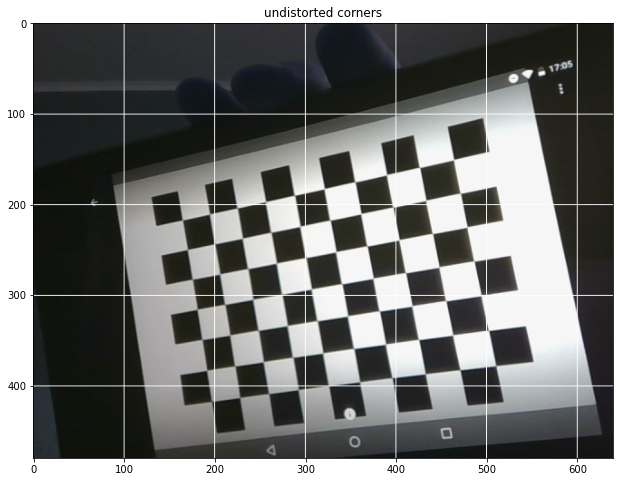

In [2]:
image_orig = cv2.imread('data/pinhole_calib/img_00.png')



#############################################################
print_image('data/pinhole_calib/img_00.png','image_orig',image_orig,0,2,0,7)
plt_view_image(plt,[["undistorted corners", draw_grid(np.copy(image_orig),100,(255,255,255))]],
               figsize=(16,8), axis='on', cmap='gray')

In [3]:
camera_matrix = np.load('data/pinhole_calib/camera_mat.npy')
dist_coefs = np.load('data/pinhole_calib/dist_coefs.npy')

No handles with labels found to put in legend.


True
------  corners------------------    Shape(70, 1, 2) corners: float32
[[163.65352 216.69199] ]
[[195.55397 210.07597] ]
[[223.92934 203.41312] ]
[[257.47073 196.18645] ]
[[287.72662 189.47139] ]
[[322.1432  182.32362] ]
[[355.4276  175.44026] ]


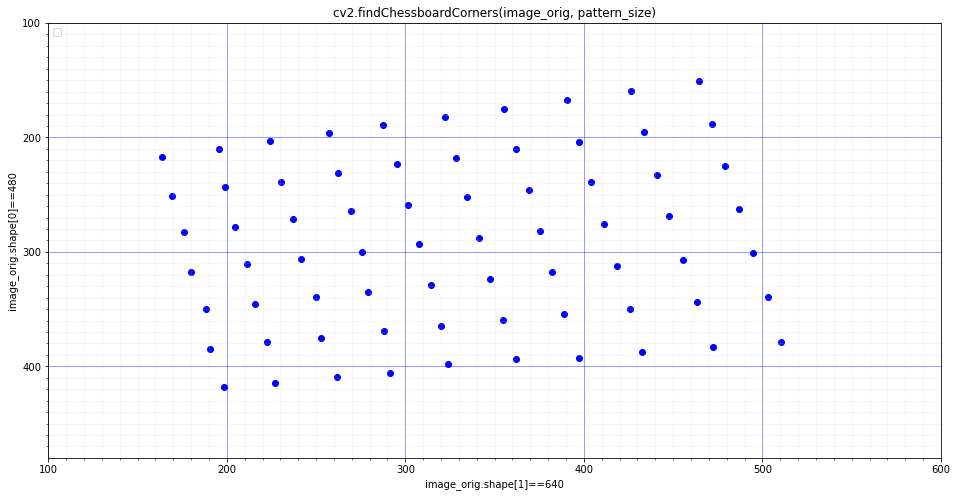

In [4]:
pattern_size = (10, 7)
res, corners = cv2.findChessboardCorners(image_orig, pattern_size)



#############################################################
print(res)
print_image('corners','corners',corners,0,7,0,7)

plt.figure(figsize=(16,8))
plt_view_grid(plt, 'on',(100,600,100,480),(100,10,100,10),major_color='b')
plt.gca().invert_yaxis()


plt.scatter(corners[:,:,0], corners[:,:,1], color='blue')
plt.xlabel('image_orig.shape[1]=={}'.format(image_orig.shape[1]));
plt.ylabel('image_orig.shape[0]=={}'.format(image_orig.shape[0]))
plt.title("cv2.findChessboardCorners(image_orig, pattern_size)");
plt.legend(loc='upper left')
plt.show()

No handles with labels found to put in legend.


------  corners------------------    Shape(70, 1, 2) corners: float32
[[164.77907 217.36673] ]
[[194.7733  210.83124] ]
[[225.23079 204.1659 ] ]
[[256.54013 197.27817] ]
[[288.47473 190.19847] ]
[[321.3794  182.80092] ]
[[355.21533 175.32439] ]
------  cornersSubPix------------    Shape(70, 1, 2) cornersSubPix: float32
[[164.77907 217.36673] ]
[[194.7733  210.83124] ]
[[225.23079 204.1659 ] ]
[[256.54013 197.27817] ]
[[288.47473 190.19847] ]
[[321.3794  182.80092] ]
[[355.21533 175.32439] ]


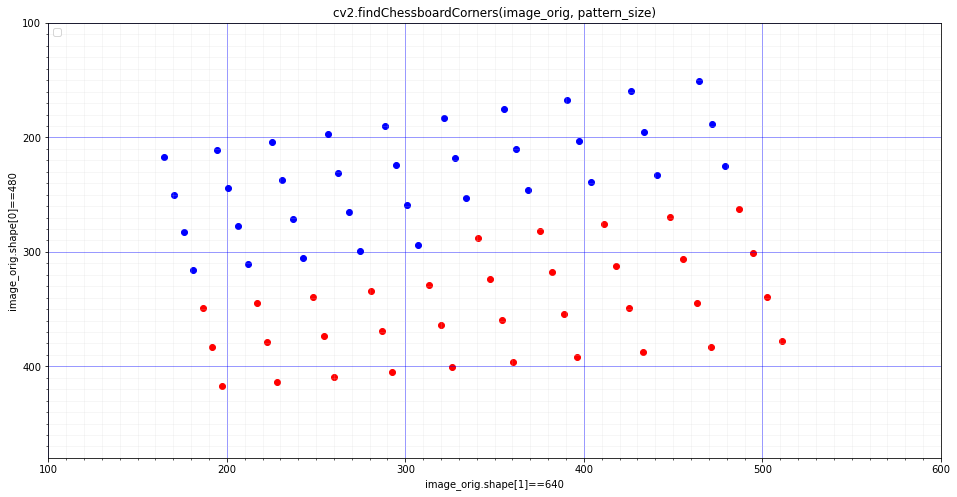

In [5]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
cornersSubPix = cv2.cornerSubPix(cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY), 
                                 corners, (10,10), (-1,-1), criteria)


##############################################################
print_image('corners','corners',corners,0,7,0,7)
print_image('cornersSubPix','cornersSubPix',cornersSubPix,0,7,0,7)


plt.figure(figsize=(16,8))
plt_view_grid(plt, 'on',(100,600,100,480),(100,10,100,10),major_color='b')
plt.gca().invert_yaxis()

plt.scatter(corners[:35,:,0], corners[:35,:,1],color='blue')
plt.scatter(cornersSubPix[35:,:,0], cornersSubPix[35:,:,1],color='red')
plt.xlabel('image_orig.shape[1]=={}'.format(image_orig.shape[1]));
plt.ylabel('image_orig.shape[0]=={}'.format(image_orig.shape[0]))
plt.title("cv2.findChessboardCorners(image_orig, pattern_size)");
plt.legend(loc='upper left')
plt.show()

In [6]:
pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)


##########################################################
print_image('[0:11]  np.zeros','pattern_points',pattern_points,0,11,0,7)
print_image('[55:70] np.zeros','pattern_points',pattern_points,55,70,0,7)

------  [0:11]  np.zeros---------    Shape(70, 3) pattern_points: float32
[ 0.0 0.0 0.0 ]
[ 1.0 0.0 0.0 ]
[ 2.0 0.0 0.0 ]
[ 3.0 0.0 0.0 ]
[ 4.0 0.0 0.0 ]
[ 5.0 0.0 0.0 ]
[ 6.0 0.0 0.0 ]
[ 7.0 0.0 0.0 ]
[ 8.0 0.0 0.0 ]
[ 9.0 0.0 0.0 ]
[ 0.0 1.0 0.0 ]
------  [55:70] np.zeros---------    Shape(70, 3) pattern_points: float32
[ 5.0 5.0 0.0 ]
[ 6.0 5.0 0.0 ]
[ 7.0 5.0 0.0 ]
[ 8.0 5.0 0.0 ]
[ 9.0 5.0 0.0 ]
[ 0.0 6.0 0.0 ]
[ 1.0 6.0 0.0 ]
[ 2.0 6.0 0.0 ]
[ 3.0 6.0 0.0 ]
[ 4.0 6.0 0.0 ]
[ 5.0 6.0 0.0 ]
[ 6.0 6.0 0.0 ]
[ 7.0 6.0 0.0 ]
[ 8.0 6.0 0.0 ]
[ 9.0 6.0 0.0 ]


In [7]:
ret, rvec, tvec = cv2.solvePnP(pattern_points, corners, camera_matrix, dist_coefs, 
                               None, None, False, cv2.SOLVEPNP_ITERATIVE)

print(ret, rvec, tvec)

True [[-0.03323431]
 [ 0.26411457]
 [-0.18734292]] [[-5.0151007 ]
 [-0.5302746 ]
 [18.62110482]]


No handles with labels found to put in legend.


------  corners------------------    Shape(70, 1, 2) corners: float32
[[164.77907 217.36673] ]
[[194.7733  210.83124] ]
[[225.23079 204.1659 ] ]
[[256.54013 197.27817] ]
[[288.47473 190.19847] ]
[[321.3794  182.80092] ]
[[355.21533 175.32439] ]
------  cornersSubPix------------    Shape(70, 1, 2) cornersSubPix: float32
[[164.77907 217.36673] ]
[[194.7733  210.83124] ]
[[225.23079 204.1659 ] ]
[[256.54013 197.27817] ]
[[288.47473 190.19847] ]
[[321.3794  182.80092] ]
[[355.21533 175.32439] ]
------  cornersSubPix------------    Shape(70, 1, 2) cornersSubPix: float32
[[164.86252 217.50221] ]
[[194.71861 210.95898] ]
[[225.23013 204.251  ] ]
[[256.46365 197.35948] ]
[[288.50162 190.2636 ] ]
[[321.43906 182.9402 ] ]
[[355.38345 175.36307] ]


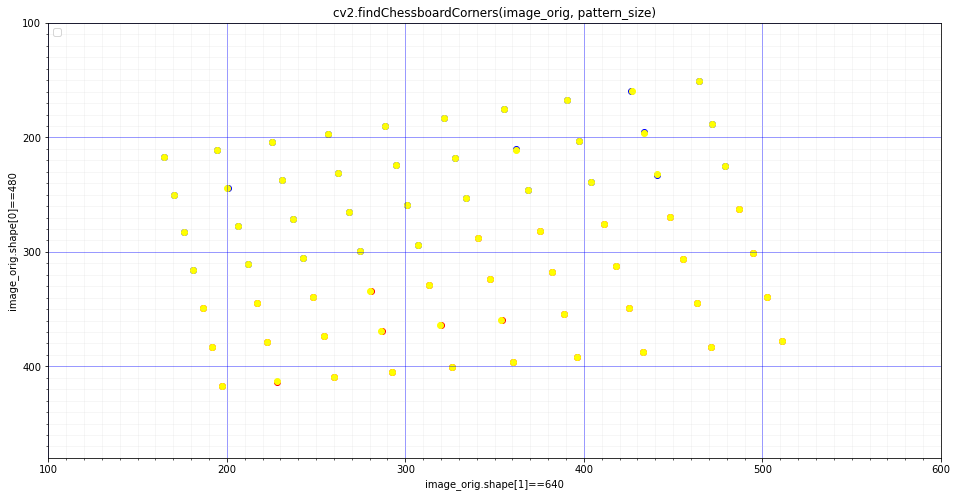

In [8]:
image_points, _ = cv2.projectPoints(pattern_points, rvec, tvec, camera_matrix, dist_coefs)



##############################################################
print_image('corners','corners',corners,0,7,0,7)
print_image('cornersSubPix','cornersSubPix',cornersSubPix,0,7,0,7)
print_image('cornersSubPix','cornersSubPix',image_points,0,7,0,7)


plt.figure(figsize=(16,8))
plt_view_grid(plt, 'on',(100,600,100,480),(100,10,100,10),major_color='b')
plt.gca().invert_yaxis()

plt.scatter(corners[:35,:,0], corners[:35,:,1],color='blue')
plt.scatter(cornersSubPix[35:,:,0], cornersSubPix[35:,:,1],color='red')
plt.scatter(image_points[:,:,0], image_points[:,:,1],color='yellow')
plt.xlabel('image_orig.shape[1]=={}'.format(image_orig.shape[1]));
plt.ylabel('image_orig.shape[0]=={}'.format(image_orig.shape[0]))
plt.title("cv2.findChessboardCorners(image_orig, pattern_size)");
plt.legend(loc='upper left')
plt.show()

<ipython-input-9-31f6f140a617>:3: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(image_circle, tuple(c), 10, (0, 255, 0), 2)


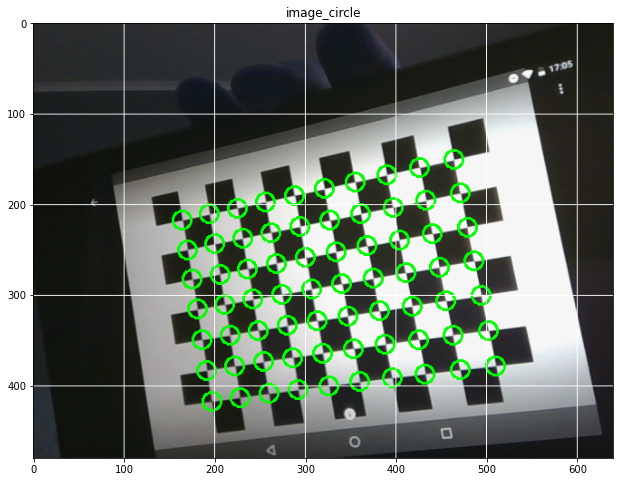

In [9]:
image_circle = np.copy(image_orig)
for c in image_points.squeeze():
    cv2.circle(image_circle, tuple(c), 10, (0, 255, 0), 2)
 

    
#############################################################
plt_view_image(plt,[["image_circle", draw_grid(np.copy(image_circle),100,(255,255,255))]],
               figsize=(16,8), axis='on', cmap='gray')